In [1]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import TabPanel, Tabs, RangeSlider, CustomJS, Column, Row, ColumnDataSource, CategoricalColorMapper
from bokeh.plotting import output_file, save

from matplotlib.pyplot import show as show_static
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import distinctipy
import glob

sys.path.append('../../')
from utils import dataframe_utils, clustering_utils

In [2]:
def smallest_unit(number):
    # Convert the number to a string to handle decimal places
    num_str = str(number)
    
    # Find the position of the decimal point
    decimal_pos = num_str.find('.')
    
    # If there's no decimal point, return 1 (for integers)
    if decimal_pos == -1:
        return 1
    
    # Calculate the length of the fractional part
    fractional_length = len(num_str) - decimal_pos - 1
    
    # Calculate the smallest unit
    smallest_unit = 10 ** (-fractional_length)
    
    return smallest_unit

In [3]:
def rgb_to_hex(rgb):
    """
    Convert RGB tuple to hexadecimal color code.
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

In [4]:
def save_parameter_comparison_plot(df_stats: pd.DataFrame, metric_colors_dict: dict, out_file_name='clustering_analysis.html', bokeh_y='nenriched_clusters'):

    df_stats.rename(columns={col: col.replace('.', '_') for col in df_stats.columns}, inplace=True)

    # resource: https://malouche.github.io/notebooks/scatter_bokeh2.html
    # PLOT 1

    tabs = []

    bokeh_data_dict = {}

    bokeh_data_dict['METRIC COMPARISON: UNFILTERED'] = df_stats

    filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

    bokeh_data_dict['METRIC COMPARISON: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
        # (df_stats['metric'] == 'cosine') &
        # (df_stats['nns'] == 3) & 
        # (df_stats['parameter'] == 0.405) & 

        (df_stats['mean_cluster_size'] > 10) &
        (df_stats['median_cluster_size'] > 10) &
        (df_stats['mean_cluster_size'] < 40) &
        (df_stats['median_cluster_size'] < 40) &
        # (df_stats['nenriched_cluster_genes'] > 7000) &
        # (df_stats['modularity'] > 0.4) &

        (df_stats['dimensionality'] == 'baseline') &
        (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats['clustering'] == 'leiden_cpm') &
        (df_stats['partition_type'] == 'EXP')
    ]

    bokeh_x = 'modularity'
    bokeh_y = bokeh_y
    # bokeh_y = 'fraction_clusters_enriched'
    color_column = 'metric'  # Column to use for coloring the points

    axis_padding = 0.05
    x_min, x_max = df_stats[bokeh_x].min() - axis_padding * df_stats[bokeh_x].min(), df_stats[bokeh_x].max() + axis_padding * df_stats[bokeh_x].max()
    y_min, y_max = df_stats[bokeh_y].min() - axis_padding * df_stats[bokeh_y].min(), df_stats[bokeh_y].max() + axis_padding * df_stats[bokeh_y].max()

    for tab_name, bokeh_df in bokeh_data_dict.items():

        p = figure(width=1000, height=800, title='HOVER OVER POINTS TO SHOW DATA. CLICK ON METRICS IN THE LEGEND TO HIDE THEM.', sizing_mode='inherit', x_range=(x_min, x_max), y_range=(y_min, y_max))

        for val in sorted(bokeh_df[color_column].unique()):
            col_df=bokeh_df.loc[(bokeh_df[color_column]==val)]
            p.scatter(bokeh_x, bokeh_y, size=3, color=metric_colors_dict[val], legend_label=val, source=col_df)

        tooltips = []
        for column in col_df.columns:
            tooltip = (column.replace('_', ' ').title(), f'@{column}')
            tooltips.append(tooltip)

        hover = HoverTool(tooltips=tooltips)

        p.add_tools(hover)

        p.legend.click_policy="hide"
        p.legend.location = "bottom_left"

        p.xaxis.axis_label = bokeh_x
        p.yaxis.axis_label = bokeh_y

        p.min_border = 100

        tabs.append(TabPanel(child=p, title=tab_name))

    plot_tabs1 = [t for t in tabs]


    # PLOT 2

    tabs = []

    bokeh_data_dict = {}

    bokeh_data_dict['DYNAMIC FILTERING: UNFILTERED'] = df_stats

    filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

    bokeh_data_dict['DYNAMIC FILTERING: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
        # (df_stats['metric'] == 'cosine') &
        # (df_stats['nns'] == 3) & 
        # (df_stats['parameter'] == 0.405) & 

        (df_stats['mean_cluster_size'] > 10) &
        (df_stats['median_cluster_size'] > 10) &
        (df_stats['mean_cluster_size'] < 40) &
        (df_stats['median_cluster_size'] < 40) &
        # (df_stats['nenriched_cluster_genes'] > 7000) &
        # (df_stats['modularity'] > 0.4) &

        (df_stats['dimensionality'] == 'baseline') &
        (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats['clustering'] == 'leiden_cpm') &
        (df_stats['partition_type'] == 'EXP')
    ]

    bokeh_x = 'modularity'
    bokeh_y = bokeh_y
    # bokeh_y = 'fraction_clusters_enriched'
    color_column = 'metric'  # Column to use for coloring the points

    axis_padding = 0.05
    x_min, x_max = df_stats[bokeh_x].min() - axis_padding * df_stats[bokeh_x].min(), df_stats[bokeh_x].max() + axis_padding * df_stats[bokeh_x].max()
    y_min, y_max = df_stats[bokeh_y].min() - axis_padding * df_stats[bokeh_y].min(), df_stats[bokeh_y].max() + axis_padding * df_stats[bokeh_y].max()

    color_mapper = CategoricalColorMapper(factors=list(metric_colors_dict.keys()), palette=list(metric_colors_dict.values()))

    for tab_name, bokeh_df in bokeh_data_dict.items():

        bokeh_data_source = ColumnDataSource(bokeh_df)

        sliders = {}


        for variable in filter_cols:

            slider_start = bokeh_df[variable].min()
            slider_end = bokeh_df[variable].max()

            if slider_start == slider_end:
                slider_end += smallest_unit(slider_end)
            
            sliders[variable] = RangeSlider(start=slider_start,
                                                end=slider_end,
                                                value=(slider_start, slider_end),
                                                step=smallest_unit(bokeh_df[variable].max()),
                                                title=f"{variable} range")


        p = figure(width=1000, height=800, title='HOVER OVER POINTS TO SHOW DATA. USE THE SLIDERS TO FILTER THE PARTITIONS.', sizing_mode='inherit', x_range=(x_min, x_max), y_range=(y_min, y_max))

        p.circle(
                x=bokeh_x,
                y=bokeh_y,
                source=bokeh_data_source,
                color={'field': color_column, 'transform': color_mapper},
                size=5,
                alpha=1,
                line_color='black'
            )

        callback = CustomJS(args=dict(source=bokeh_data_source, sliders=sliders), code="""
            const data = source.data;
            const indices = [];
            const variables = Object.keys(sliders);
            
            for (let i = 0; i < data['index'].length; i++) {
                let include = true;
                
                for (const variable of variables) {
                    const slider_range = sliders[variable].value;
                    const value = data[variable][i];
                    
                    if (value < slider_range[0] || value > slider_range[1]) {
                        include = false;
                        break;
                    }
                }
                
                if (include) {
                    indices.push(i);
                }
            }
            
            source.selected.indices = indices;
            source.change.emit();
        """)

        # Attach the callback to all sliders
        for slider in sliders.values():
            slider.js_on_change('value', callback)

        # Add all sliders to a layout
        slider_layout = Column(*sliders.values())

        tooltips = []
        for column in bokeh_df.columns:
            tooltip = (column.replace('_', ' ').title(), f'@{column}')
            tooltips.append(tooltip)

        hover = HoverTool(tooltips=tooltips)

        p.add_tools(hover)

        # p.legend.click_policy="hide"
        # p.legend.location = "bottom_left"

        p.xaxis.axis_label = bokeh_x
        p.yaxis.axis_label = bokeh_y

        p.min_border = 100

        slider_layout.margin = 100

        layout = Row(p, slider_layout)

        tabs.append(TabPanel(child=layout, title=tab_name))

    plot_tabs2 = [t for t in tabs]

    # SAVE PLOTS

    tabbed_plot = Tabs(tabs=(plot_tabs1 + plot_tabs2))

    output_file(f'./{out_file_name}')

    save(tabbed_plot)

In [5]:
microarray_data_pattern = './tgd2024_may15_avg_scan_stats_microarray/*.csv'

rna_seq_data_pattern = './tgd2024_may15_avg_scan_stats_rna_seq/*.csv'

microarray_stats_files = glob.glob(microarray_data_pattern)

rna_seq_stats_files = glob.glob(rna_seq_data_pattern)

microarray_stats_df = dataframe_utils.csv_files_to_df(microarray_stats_files)

rna_seq_stats_df = dataframe_utils.csv_files_to_df(rna_seq_stats_files)

/Users/michaelbertagna/git/TGNE-2022/TGNE/clustering_optimization/../../utils/dataframe_utils.py:64: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  curr_df = pd.read_csv(f, sep=sep, names=cols)
/Users/michaelbertagna/git/TGNE-2022/TGNE/clustering_optimization/../../utils/dataframe_utils.py:64: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  curr_df = pd.read_csv(f, sep=sep, names=cols)
/Users/michaelbertagna/git/TGNE-2022/TGNE/clustering_optimization/../../utils/dataframe_utils.py:64: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  curr_df = pd.read_csv(f, sep=sep, name

In [6]:
microarray_stats_df['fraction_clusters_enriched'] = microarray_stats_df.apply(clustering_utils.compute_fraction_clusters_enriched, axis=1)

In [7]:
microarray_stats_df['metric'].unique()

array(['manhattan'], dtype=object)

In [8]:
microarray_stats_df.columns

Index(['partition_type', 'dimensionality', 'metric', 'graph', 'nns',
       'clustering', 'parameter', 'silhouette_score', 'modularity',
       'nclusters', 'mean_cluster_size', 'median_cluster_size',
       'sd_cluster_size', 'max_cluster_size', 'min_cluster_size', 'ngenes',
       'nenriched_clusters', 'mean_enriched_cluster_size',
       'median_enriched_cluster_size', 'sd_enriched_cluster_size',
       'max_enriched_cluster_size', 'min_enriched_cluster_size',
       'nenriched_cluster_genes', 'datetime',
       'max_fraction_same_cluster_MCMsubset.tsv',
       'max_fraction_same_cluster_ProteosomeSubset.tsv',
       'max_fraction_same_cluster_Histone_subset.tsv',
       'max_fraction_same_cluster_MucocystSubsets.tsv',
       'max_fraction_same_cluster_RibosomalSubset.tsv',
       'fraction_clusters_enriched'],
      dtype='object')

In [9]:
{col: type(microarray_stats_df[col].values[0]) for col in list(microarray_stats_df.columns)}

{'partition_type': str,
 'dimensionality': str,
 'metric': str,
 'graph': str,
 'nns': numpy.int64,
 'clustering': str,
 'parameter': numpy.float64,
 'silhouette_score': numpy.float64,
 'modularity': numpy.float64,
 'nclusters': numpy.int64,
 'mean_cluster_size': numpy.float64,
 'median_cluster_size': numpy.float64,
 'sd_cluster_size': numpy.float64,
 'max_cluster_size': numpy.int64,
 'min_cluster_size': numpy.int64,
 'ngenes': numpy.int64,
 'nenriched_clusters': numpy.int64,
 'mean_enriched_cluster_size': numpy.float64,
 'median_enriched_cluster_size': numpy.float64,
 'sd_enriched_cluster_size': numpy.float64,
 'max_enriched_cluster_size': numpy.int64,
 'min_enriched_cluster_size': numpy.int64,
 'nenriched_cluster_genes': numpy.int64,
 'datetime': str,
 'max_fraction_same_cluster_MCMsubset.tsv': numpy.float64,
 'max_fraction_same_cluster_ProteosomeSubset.tsv': numpy.float64,
 'max_fraction_same_cluster_Histone_subset.tsv': numpy.float64,
 'max_fraction_same_cluster_MucocystSubsets.tsv

In [10]:
[col for col in list(microarray_stats_df.columns) if isinstance(microarray_stats_df[col].values[0], (int, float, np.int64, np.float64))]

['nns',
 'parameter',
 'silhouette_score',
 'modularity',
 'nclusters',
 'mean_cluster_size',
 'median_cluster_size',
 'sd_cluster_size',
 'max_cluster_size',
 'min_cluster_size',
 'ngenes',
 'nenriched_clusters',
 'mean_enriched_cluster_size',
 'median_enriched_cluster_size',
 'sd_enriched_cluster_size',
 'max_enriched_cluster_size',
 'min_enriched_cluster_size',
 'nenriched_cluster_genes',
 'max_fraction_same_cluster_MCMsubset.tsv',
 'max_fraction_same_cluster_ProteosomeSubset.tsv',
 'max_fraction_same_cluster_Histone_subset.tsv',
 'max_fraction_same_cluster_MucocystSubsets.tsv',
 'max_fraction_same_cluster_RibosomalSubset.tsv',
 'fraction_clusters_enriched']

In [11]:
rna_seq_stats_df['fraction_clusters_enriched'] = rna_seq_stats_df.apply(clustering_utils.compute_fraction_clusters_enriched, axis=1)

In [12]:
rna_seq_stats_df['metric'].unique()

array(['manhattan'], dtype=object)

In [13]:
rna_seq_stats_df.columns

Index(['partition_type', 'dimensionality', 'metric', 'graph', 'nns',
       'clustering', 'parameter', 'silhouette_score', 'modularity',
       'nclusters', 'mean_cluster_size', 'median_cluster_size',
       'sd_cluster_size', 'max_cluster_size', 'min_cluster_size', 'ngenes',
       'nenriched_clusters', 'mean_enriched_cluster_size',
       'median_enriched_cluster_size', 'sd_enriched_cluster_size',
       'max_enriched_cluster_size', 'min_enriched_cluster_size',
       'nenriched_cluster_genes', 'datetime',
       'max_fraction_same_cluster_MCMsubset.tsv',
       'max_fraction_same_cluster_ProteosomeSubset.tsv',
       'max_fraction_same_cluster_Histone_subset.tsv',
       'max_fraction_same_cluster_MucocystSubsets.tsv',
       'max_fraction_same_cluster_RibosomalSubset.tsv',
       'fraction_clusters_enriched'],
      dtype='object')

In [14]:
{col: type(rna_seq_stats_df[col].values[0]) for col in list(rna_seq_stats_df.columns)}

{'partition_type': str,
 'dimensionality': str,
 'metric': str,
 'graph': str,
 'nns': numpy.int64,
 'clustering': str,
 'parameter': numpy.float64,
 'silhouette_score': numpy.float64,
 'modularity': numpy.float64,
 'nclusters': numpy.int64,
 'mean_cluster_size': numpy.float64,
 'median_cluster_size': numpy.float64,
 'sd_cluster_size': numpy.float64,
 'max_cluster_size': numpy.int64,
 'min_cluster_size': numpy.int64,
 'ngenes': numpy.int64,
 'nenriched_clusters': numpy.int64,
 'mean_enriched_cluster_size': numpy.float64,
 'median_enriched_cluster_size': numpy.float64,
 'sd_enriched_cluster_size': numpy.float64,
 'max_enriched_cluster_size': numpy.int64,
 'min_enriched_cluster_size': numpy.int64,
 'nenriched_cluster_genes': numpy.int64,
 'datetime': str,
 'max_fraction_same_cluster_MCMsubset.tsv': numpy.float64,
 'max_fraction_same_cluster_ProteosomeSubset.tsv': numpy.float64,
 'max_fraction_same_cluster_Histone_subset.tsv': numpy.float64,
 'max_fraction_same_cluster_MucocystSubsets.tsv

In [15]:
[col for col in list(rna_seq_stats_df.columns) if isinstance(rna_seq_stats_df[col].values[0], (int, float, np.int64, np.float64))]

['nns',
 'parameter',
 'silhouette_score',
 'modularity',
 'nclusters',
 'mean_cluster_size',
 'median_cluster_size',
 'sd_cluster_size',
 'max_cluster_size',
 'min_cluster_size',
 'ngenes',
 'nenriched_clusters',
 'mean_enriched_cluster_size',
 'median_enriched_cluster_size',
 'sd_enriched_cluster_size',
 'max_enriched_cluster_size',
 'min_enriched_cluster_size',
 'nenriched_cluster_genes',
 'max_fraction_same_cluster_MCMsubset.tsv',
 'max_fraction_same_cluster_ProteosomeSubset.tsv',
 'max_fraction_same_cluster_Histone_subset.tsv',
 'max_fraction_same_cluster_MucocystSubsets.tsv',
 'max_fraction_same_cluster_RibosomalSubset.tsv',
 'fraction_clusters_enriched']

In [16]:
len(rna_seq_stats_df['metric'].unique()), len(microarray_stats_df['metric'].unique())

(1, 1)

In [17]:
# https://en.wikipedia.org/wiki/Pareto_front
# https://en.wikipedia.org/wiki/Maxima_of_a_point_set

def maxima_of_a_point_set(points):
    sorted_points = sorted(points, key=lambda p: p[0])

    max_y = float('-inf')
    maximal_points = []

    for point in reversed(sorted_points):
        x, y, idx = point
        if y > max_y:
            maximal_points.append(point)
            max_y = y

    return maximal_points

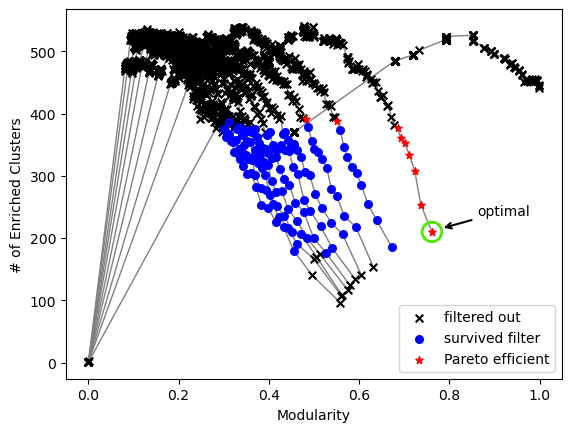

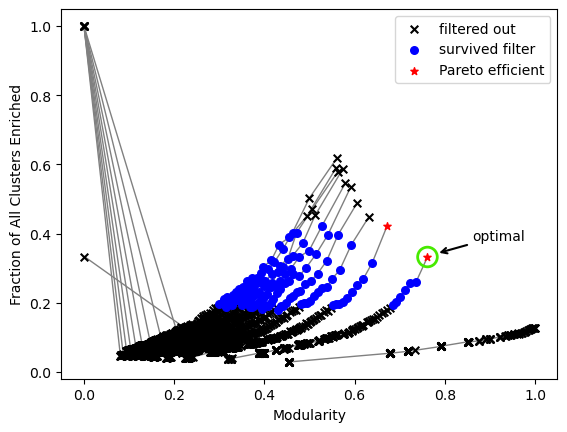

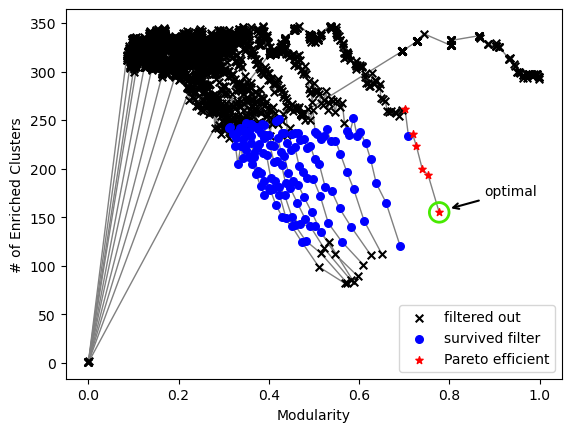

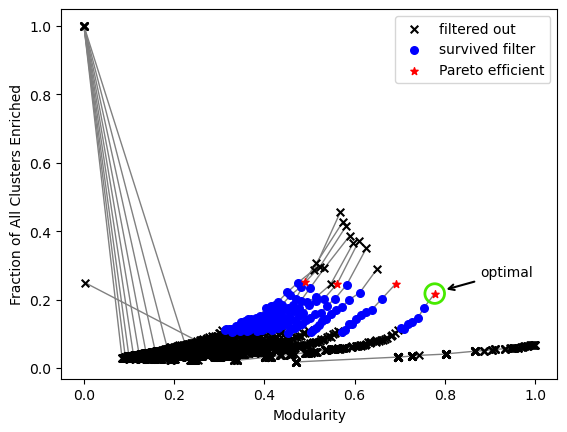

In [42]:
y_all_stats = ['nenriched_clusters', 'fraction_clusters_enriched']

dfs = [microarray_stats_df, 
       rna_seq_stats_df]

# dfs = [microarray_stats_df.loc[(microarray_stats_df['parameter'] > 0) & (microarray_stats_df['parameter'] < 1)].reset_index(), 
#        rna_seq_stats_df.loc[(rna_seq_stats_df['parameter'] > 0) & (rna_seq_stats_df['parameter'] < 1)].reset_index()]

for df in dfs:
   for y_all_stat in y_all_stats:

      x_all = df['modularity'].values

      y_all = df[y_all_stat].values

      conditions = (
         (df['mean_cluster_size'] >= 10)
         &
         (df['median_cluster_size'] >= 10)
         &
         (df['mean_cluster_size'] <= 50)
         &
         (df['median_cluster_size'] <= 50)
      )

      filtered_df = df.loc[conditions]

      x = filtered_df['modularity'].values

      y = filtered_df[y_all_stat].values

      filtered_idxs = filtered_df.index.tolist()

      points = zip(x, y, filtered_idxs)

      max_points = np.array(maxima_of_a_point_set(points))
      max_point_idxs = [int(pt[2]) for pt in max_points]

      filtered_non_max_idxs = list(set(filtered_idxs) - set(max_point_idxs))

      other_idxs = list(set(df.index.tolist()) - set(filtered_idxs))

      global_s = 30

      plt.scatter(x_all[other_idxs], y_all[other_idxs], color='black', marker='x', s=global_s, label='filtered out', zorder=1)

      plt.scatter(x_all[filtered_non_max_idxs], y_all[filtered_non_max_idxs], color='blue', s=global_s, label='survived filter', zorder=1)

      plt.scatter(x_all[max_point_idxs], y_all[max_point_idxs], color='red', marker='*', s=global_s, label='Pareto efficient', zorder=1)

      max_modularity_idx = np.argmax(x_all[max_point_idxs])

      center_x = x_all[max_point_idxs][max_modularity_idx]
      center_y = y_all[max_point_idxs][max_modularity_idx]
      plt.scatter([center_x], [center_y], facecolors='none', edgecolor='#47EA00', linewidth=2, s=200, zorder=1
                  #  label='chosen parition'
                  )

      # plt.annotate('', xy=(center_x, center_y), xytext=(center_x, center_y),
      #              arrowprops=dict(facecolor='#47EA00', 
      #                              arrowstyle="->",
      #                             #  shrink=0.05
      #                              ),
      #             #  rotation=45
      #              )

      x_extreme = x_all.max() if x_all.max() > abs(x_all.min()) else x_all.min()
      y_exterme = y_all.max() if y_all.max() > abs(y_all.min()) else y_all.min()

      plt.annotate('optimal', xy=(center_x + x_extreme*0.02, center_y + y_exterme/100), xytext=(center_x + x_extreme*0.1, center_y + y_exterme/20), zorder=1,
                  arrowprops=dict(
                     #  color='#47EA00', 
                     arrowstyle="->", 
                     relpos=(1, 1), 
                     lw=1.5,
                     ))

      plt.xlabel('Modularity')
      plt.ylabel('# of Enriched Clusters' if y_all_stat == 'nenriched_clusters' else 'Fraction of All Clusters Enriched')
      plt.legend()

      for nns_value, group in df.groupby('nns'):
         group_df = group.copy(deep=True).sort_values(by='modularity')
         plt.plot(group_df['modularity'], group_df[y_all_stat], color='grey', linestyle='-', linewidth=1, zorder=-1)

      plt.show()

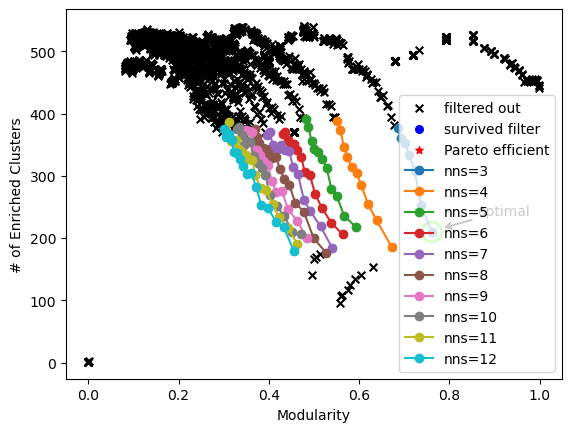

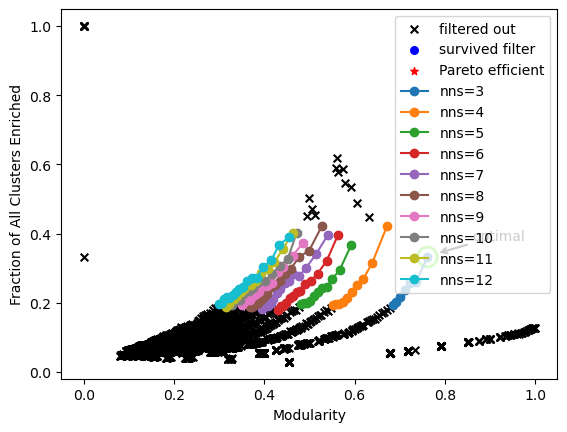

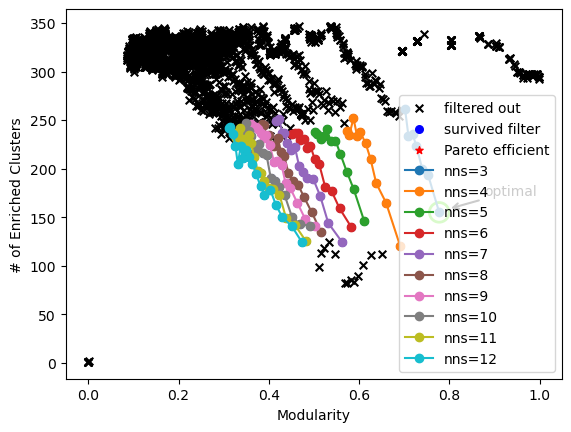

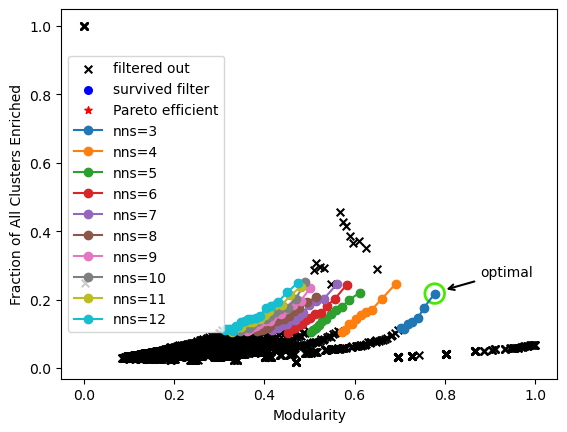

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt

# y_all_stats = ['nenriched_clusters', 'fraction_clusters_enriched']
# dfs = [microarray_stats_df, rna_seq_stats_df]

# for df in dfs:
#     for y_all_stat in y_all_stats:
#         x_all = df['modularity'].values
#         y_all = df[y_all_stat].values

#         conditions = (
#             (df['mean_cluster_size'] >= 10) &
#             (df['median_cluster_size'] >= 10) &
#             (df['mean_cluster_size'] <= 50) &
#             (df['median_cluster_size'] <= 50)
#         )

#         filtered_df = df.loc[conditions]
#         x = filtered_df['modularity'].values
#         y = filtered_df[y_all_stat].values
#         filtered_idxs = filtered_df.index.tolist()

#         points = list(zip(x, y, filtered_idxs))
#         max_points = np.array(maxima_of_a_point_set(points))
#         max_point_idxs = [int(pt[2]) for pt in max_points]

#         filtered_non_max_idxs = list(set(filtered_idxs) - set(max_point_idxs))
#         other_idxs = list(set(df.index.tolist()) - set(filtered_idxs))

#         global_s = 30

#         plt.scatter(x_all[other_idxs], y_all[other_idxs], color='black', marker='x', s=global_s, label='filtered out')
#         plt.scatter(x_all[filtered_non_max_idxs], y_all[filtered_non_max_idxs], color='blue', s=global_s, label='survived filter')
#         plt.scatter(x_all[max_point_idxs], y_all[max_point_idxs], color='red', marker='*', s=global_s, label='Pareto efficient')

#         max_modularity_idx = np.argmax(x_all[max_point_idxs])
#         center_x = x_all[max_point_idxs][max_modularity_idx]
#         center_y = y_all[max_point_idxs][max_modularity_idx]
#         plt.scatter([center_x], [center_y], facecolors='none', edgecolor='#47EA00', linewidth=2, s=200)

#         x_extreme = x_all.max() if x_all.max() > abs(x_all.min()) else x_all.min()
#         y_extreme = y_all.max() if y_all.max() > abs(y_all.min()) else y_all.min()

#         plt.annotate('optimal', xy=(center_x + x_extreme*0.02, center_y + y_extreme/100), xytext=(center_x + x_extreme*0.1, center_y + y_extreme/20),
#                      arrowprops=dict(arrowstyle="->", lw=1.5))

#         # Connecting points with the same 'nns' value
#         for nns_value, group in df.groupby('nns'):
#             group_filtered = group.loc[conditions]
#             if not group_filtered.empty:
#                 plt.plot(group_filtered['modularity'], group_filtered[y_all_stat], linestyle='-', marker='o', label=f'nns={nns_value}')

#         plt.xlabel('Modularity')
#         plt.ylabel('# of Enriched Clusters' if y_all_stat == 'nenriched_clusters' else 'Fraction of All Clusters Enriched')
#         plt.legend()

#         plt.show()


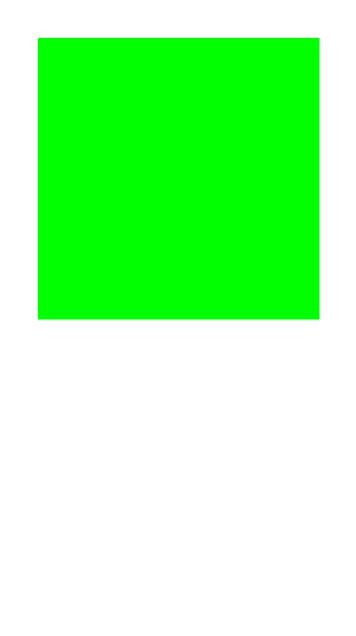

In [19]:
num_colors = len(rna_seq_stats_df['metric'].unique())
colors = distinctipy.get_colors(num_colors)
distinctipy.color_swatch(colors)
metric_colors_dict = {m : rgb_to_hex(colors[idx]) for idx, m in enumerate(rna_seq_stats_df['metric'].unique())}

In [20]:
save_parameter_comparison_plot(microarray_stats_df, metric_colors_dict=metric_colors_dict, out_file_name='microarray_stats_plot.html')
save_parameter_comparison_plot(rna_seq_stats_df, metric_colors_dict=metric_colors_dict, out_file_name='rna_seq_stats_plot.html')

In [21]:
save_parameter_comparison_plot(microarray_stats_df, metric_colors_dict=metric_colors_dict, out_file_name='microarray_stats_plot_fract.html', bokeh_y='fraction_clusters_enriched')
save_parameter_comparison_plot(rna_seq_stats_df, metric_colors_dict=metric_colors_dict, out_file_name='rna_seq_stats_plot_fract.html', bokeh_y='fraction_clusters_enriched')